Objetivo general: Determinar los factores pronóstico de mortalidad en pacientes con Neumonía grave por Covid 19 ingresados en la Unidad de Cuidados Intensivos.
Se realizó una investigación analítica transversal, en la Unidad de Cuidados Intensivos del Hospital Militar Comandante Manuel Fajardo Rivero, desde  enero 2023 a noviembre 2025. 
El estudio fue realizado en toda la población constituida por los pacientes ingresados en la UCI con diagnóstico de Neumonía Grave por Covid 19 en el año 2021.

Datos Recogidos:

1. Datos Demográficos
- Edad
- Sexo
2. APP: Antecedentes Patológicos Personales
- APPHTA: Hipertensión arterial 
- APPDM: Diabetes mellitus 
- APPEPOC: Enfermedad Pulmonar Obstructiva Crónica 
- APPPERC: 
- APPCardiopatia Isquemica
- APPAsma Bronquial
- APP obesidad:
3. Medicamentos/Tratamientos
- Dobutamina
- Norepinefrina
4. Condiciones Clínicas Agudas
- TEP: Tromboembolismo pulmonar 
- Insuficiencia renal aguda
- Shock séptico
- ARDS: Síndrome de dificultad respiratoria aguda
- Sobreinfección Bacteriana
5. Marcadores de Laboratorio
- Dimero D: Proteína en sangre que indica coagulación anormal
- PCR: Proteína C-reactiva
- Ferritina: Proteína que almacena hierro
- LDH: Lactato deshidrogenasa 
- Índice neutrófilos/linfocitos
6. Parámetros Clínicos y de Gravedad
- APACHE II al ingreso: Puntuación pronóstica en UCI (evalúa edad, signos vitales y laboratorio).
- PaO2/FiO2 al ingreso: Ratio oxigenación (bajo en ARDS o falla respiratoria).
7. Factores de Tratamiento
- Días de VAM: Días en ventilación asistida mecánica
- Días de retardo en recibir atención médica
8. Desenlace.
- Egreso: Estado al salir del hospital (supervivencia vs mortalidad).



In [89]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV 
from scipy.stats import pointbiserialr
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import roc_auc_score , roc_curve  , confusion_matrix ,ConfusionMatrixDisplay

In [90]:
#Cargar los datos
data_set = pd.read_excel("C:/Users/David_858/Desktop/PROYRCTO ML/base_datos_pr.xlsx" ,sheet_name="Hoja1" )
data_set.drop("Nombre y apellidos" , axis="columns" , inplace=True)
#RENOMBRAR LOS ATRIBUTOS
new_columns = {'Edad':"edad", 'Sexo':"sexo",'APPCardiopatia Isquemica':"APPCI",'APPAsma Bronquial':"APPAB",'Dobutamina':"dobutamina",
 'Norepinefrina':"norepinefrina", 'Insuficiencia renal aguda':"ins_renal_aguda",'Shock séptico':"shock_septico",
 'Sobreinfección Bacteriana  ':"sobreinf_bac",'Días de VAM':"dias_vam",'Egreso':"egreso",'Dimero D':"dimero_d",'APP obesidad ':"APPO",
 'APACHE II al ingreso':"apache_II",'PaO2/FiO2 al ingreso':"PaO2/Fio2",'Ferritina':"ferritina",'Días de retardo en recibir atencion medica ':"dias_retraso",
 'índice neutrofilos /linfositos  ':"neutro/linfo"}
data_set.rename(columns=new_columns ,inplace=True)
#Extraer las caracteristicas categoricas y numericas para analisis
categorical_cols = [col  for col in data_set.columns  if data_set[col].nunique()==2 and col != 'egreso']
numeric_cols = [col for col in data_set.columns if col not in categorical_cols and col != 'egreso']
data_set[numeric_cols].describe()
#Rellenar valores faltantes con la mediana (2 casos : 18 , 20)
for column in numeric_cols:
    data_set[column]=data_set[column].fillna( value=data_set[column].median())
data_set['sexo']=data_set['sexo']-1
data_set.describe()

,edad,sexo,APPHTA,APPDM,APPEPOC,APPERC,APPCI,APPAB,dobutamina,norepinefrina,...,dimero_d,ARDS,APPO,apache_II,PaO2/Fio2,PCR,ferritina,dias_retraso,neutro/linfo,LDH
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,...,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,63.159091,0.409091,0.530303,0.265152,0.159091,0.181818,0.219697,0.159091,0.159091,0.348485,...,578.287879,0.757576,0.310606,15.962121,172.204545,60.174242,456.727273,5.212121,3.934848,762.765152
std,17.622344,0.493539,0.500982,0.443095,0.367154,0.387164,0.415619,0.367154,0.367154,0.478306,...,647.114258,0.430182,0.464505,14.996898,77.021633,24.749276,226.627577,2.011533,0.805798,401.819713
min,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,43.000000,0.000000,0.000000,0.000000,54.000000,23.000000,56.000000,1.000000,2.300000,213.000000
25%,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,95.000000,1.000000,0.000000,12.000000,104.500000,46.000000,320.000000,4.000000,3.300000,452.500000
50%,61.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,350.500000,1.000000,0.000000,15.000000,145.500000,54.000000,451.500000,5.000000,4.000000,654.000000
75%,76.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,736.250000,1.000000,1.000000,17.000000,226.250000,65.000000,571.000000,6.000000,4.425000,993.000000
max,101.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3450.000000,1.000000,1.000000,180.000000,345.000000,156.000000,1421.000000,11.000000,6.400000,2340.000000


In [91]:
#Target Desbalanceado
fallecidos=data_set["egreso"][data_set.egreso==1].sum()
print(f"fallecidos: {fallecidos/len(data_set)*100}%")
#Separar el conjunto de test del conjunto de entrenamiento 
train_set, test_set = train_test_split(
    data_set,
    test_size=0.20,        
    random_state=15,      
    stratify=data_set['egreso']  #mantener la misma proporcion del target en train_set y test_set
)



fallecidos: 68.18181818181817%


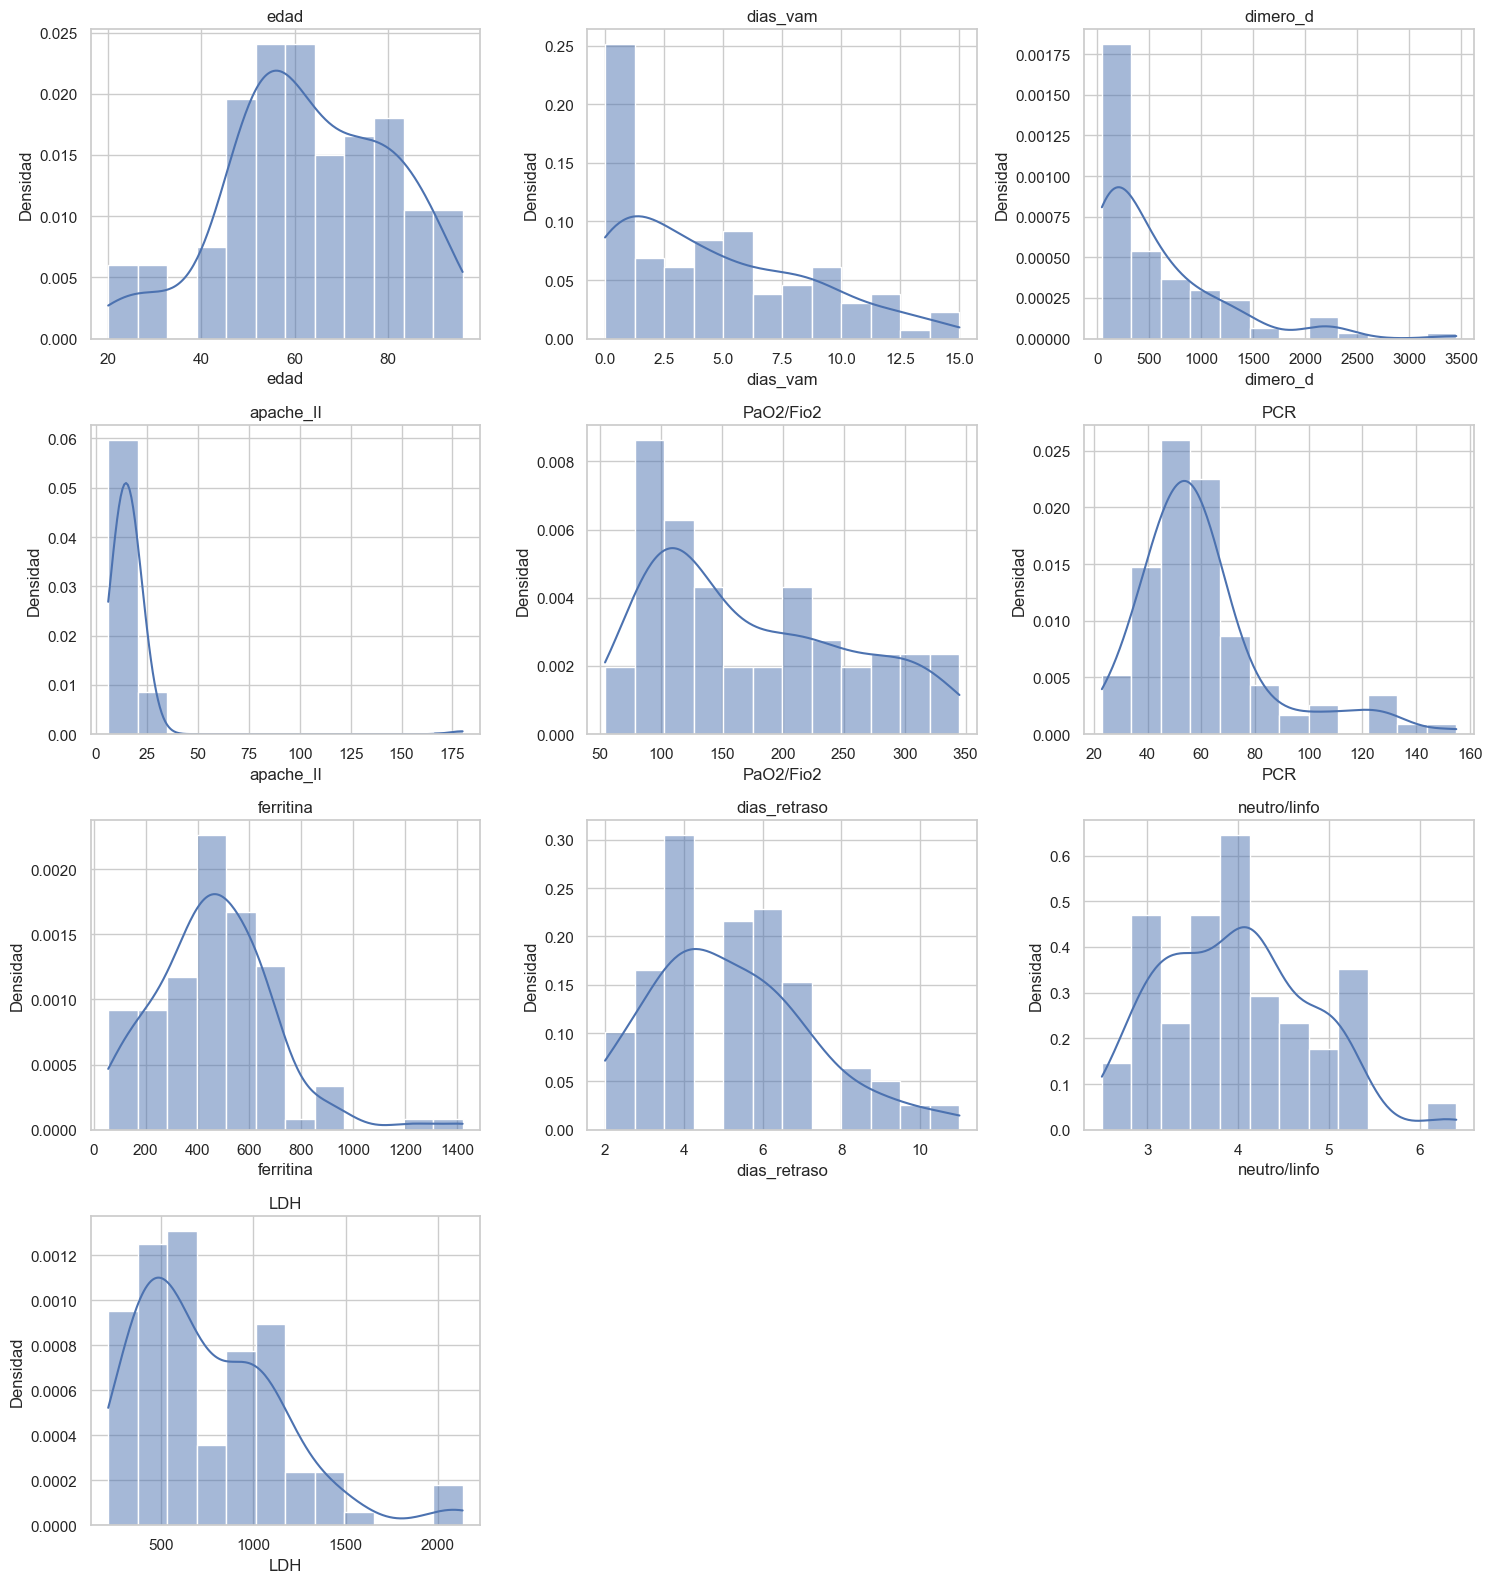

In [92]:
#Analizar la distribucion y buscar psoibles valores erroneos en las varaibles numericas
import math
n = len(numeric_cols)
cols = 3  
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()  
for i, col in enumerate(numeric_cols):
    sns.histplot(train_set[col], kde=True, stat='density', bins=12, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')
    axes[i].grid(True)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

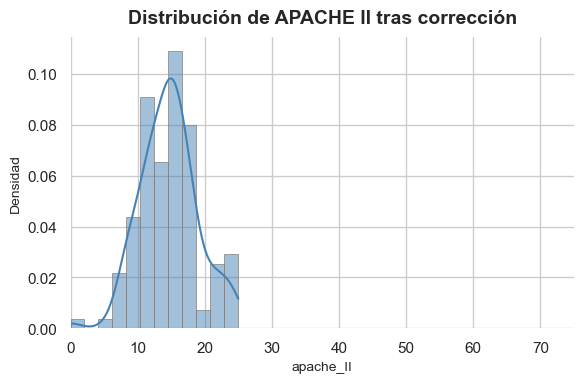

In [93]:
#El apache II tiene un rango de valores registrado de 0-71 ,valores por encima de 40 son muy infrecuentes.
# La grafica muestra que existen outliers para este campo
data_set.loc[data_set["apache_II"] > 71, "apache_II"] = median_apache = data_set.loc[data_set["apache_II"] <= 71, "apache_II"].median()
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
sns.histplot(
    data_set["apache_II"],
    kde=True,            
    stat="density",    
    bins=12,             
    color="steelblue",   
    edgecolor="gray",
    linewidth=0.5
)
plt.title("Distribución de APACHE II tras corrección", fontsize=14, weight="bold", pad=10)
plt.xlabel("apache_II", fontsize=10)
plt.ylabel("Densidad", fontsize=10)
plt.grid(True)
plt.xlim(0, 75)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [94]:
#  correlación punto-biserial entre variables numericas y el target
correlaciones = {}
for col in numeric_cols:
        correlacion, p_valor = pointbiserialr(train_set[col], train_set["egreso"])
        correlaciones[col] = correlacion
df_correlaciones = pd.DataFrame({
    "Atributo": correlaciones.keys(),
    "Correlación": correlaciones.values()
}).sort_values(by="Correlación", key=abs, ascending=False)     
df_correlaciones

,Atributo,Correlación
0,edad,0.612607
9,LDH,0.498631
6,ferritina,0.413874
4,PaO2/Fio2,-0.376857
2,dimero_d,0.358474
5,PCR,0.308373
7,dias_retraso,0.256325
1,dias_vam,0.052205
8,neutro/linfo,-0.027139
3,apache_II,-0.018489


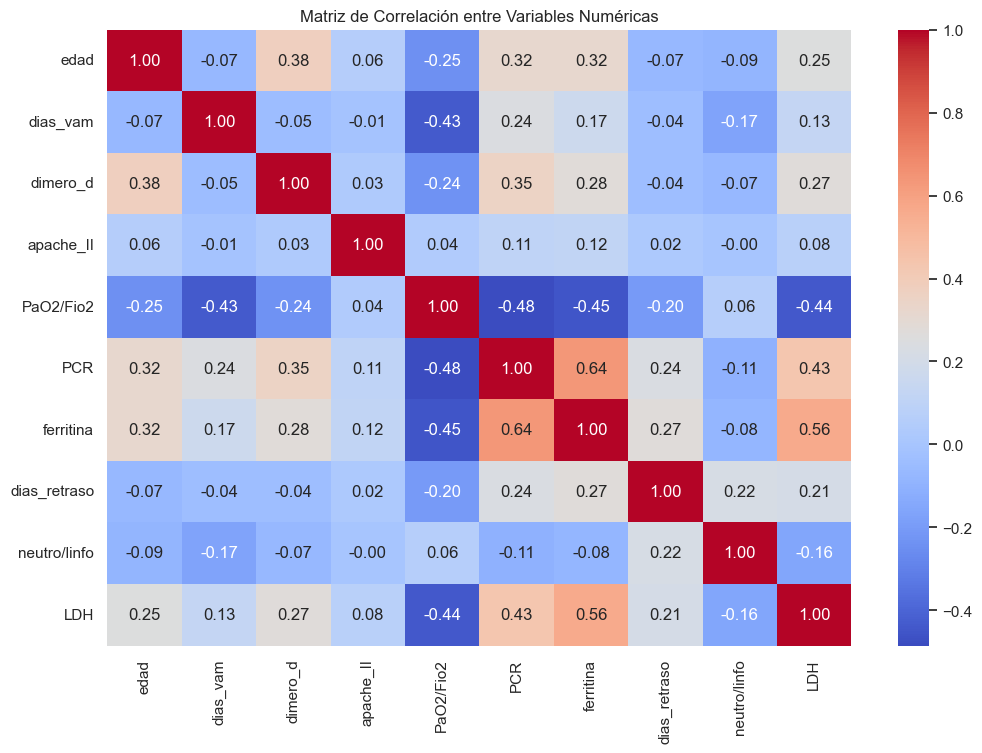

In [95]:
#Identificar si existe correlacion muy fuerte entre pares de predictores , pues pueden ser eliminados por RFE 
# y tener importancia para el problema medico.
plt.figure(figsize=(12, 8))
sns.heatmap(train_set[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

In [96]:
#Analizar el balance de las caracteristicas categoricas (todas son binarias)
frecuencias= pd.DataFrame([] , index=categorical_cols)
for col in frecuencias.index:
    frecuencias.loc[col ,"frecuencia_absoluta"]=train_set[col].sum()
    frecuencias.loc[col ,"frecuencia_relativa"]=frecuencias.loc[col ,"frecuencia_absoluta"]/(len(train_set))*100
    frecuencias.loc[col ,"tasa_mortalidad %"]=train_set.loc[train_set[col].astype(bool) , 'egreso'].sum()/frecuencias.loc[col ,"frecuencia_absoluta"]*100 
    
frecuencias

,frecuencia_absoluta,frecuencia_relativa,tasa_mortalidad %
sexo,44.0,41.904762,63.636364
APPHTA,56.0,53.333333,85.714286
APPDM,29.0,27.619048,86.206897
APPEPOC,17.0,16.190476,76.470588
APPERC,20.0,19.047619,90.000000
APPCI,22.0,20.952381,95.454545
APPAB,14.0,13.333333,14.285714
dobutamina,16.0,15.238095,93.750000
norepinefrina,36.0,34.285714,91.666667
TEP,23.0,21.904762,100.000000


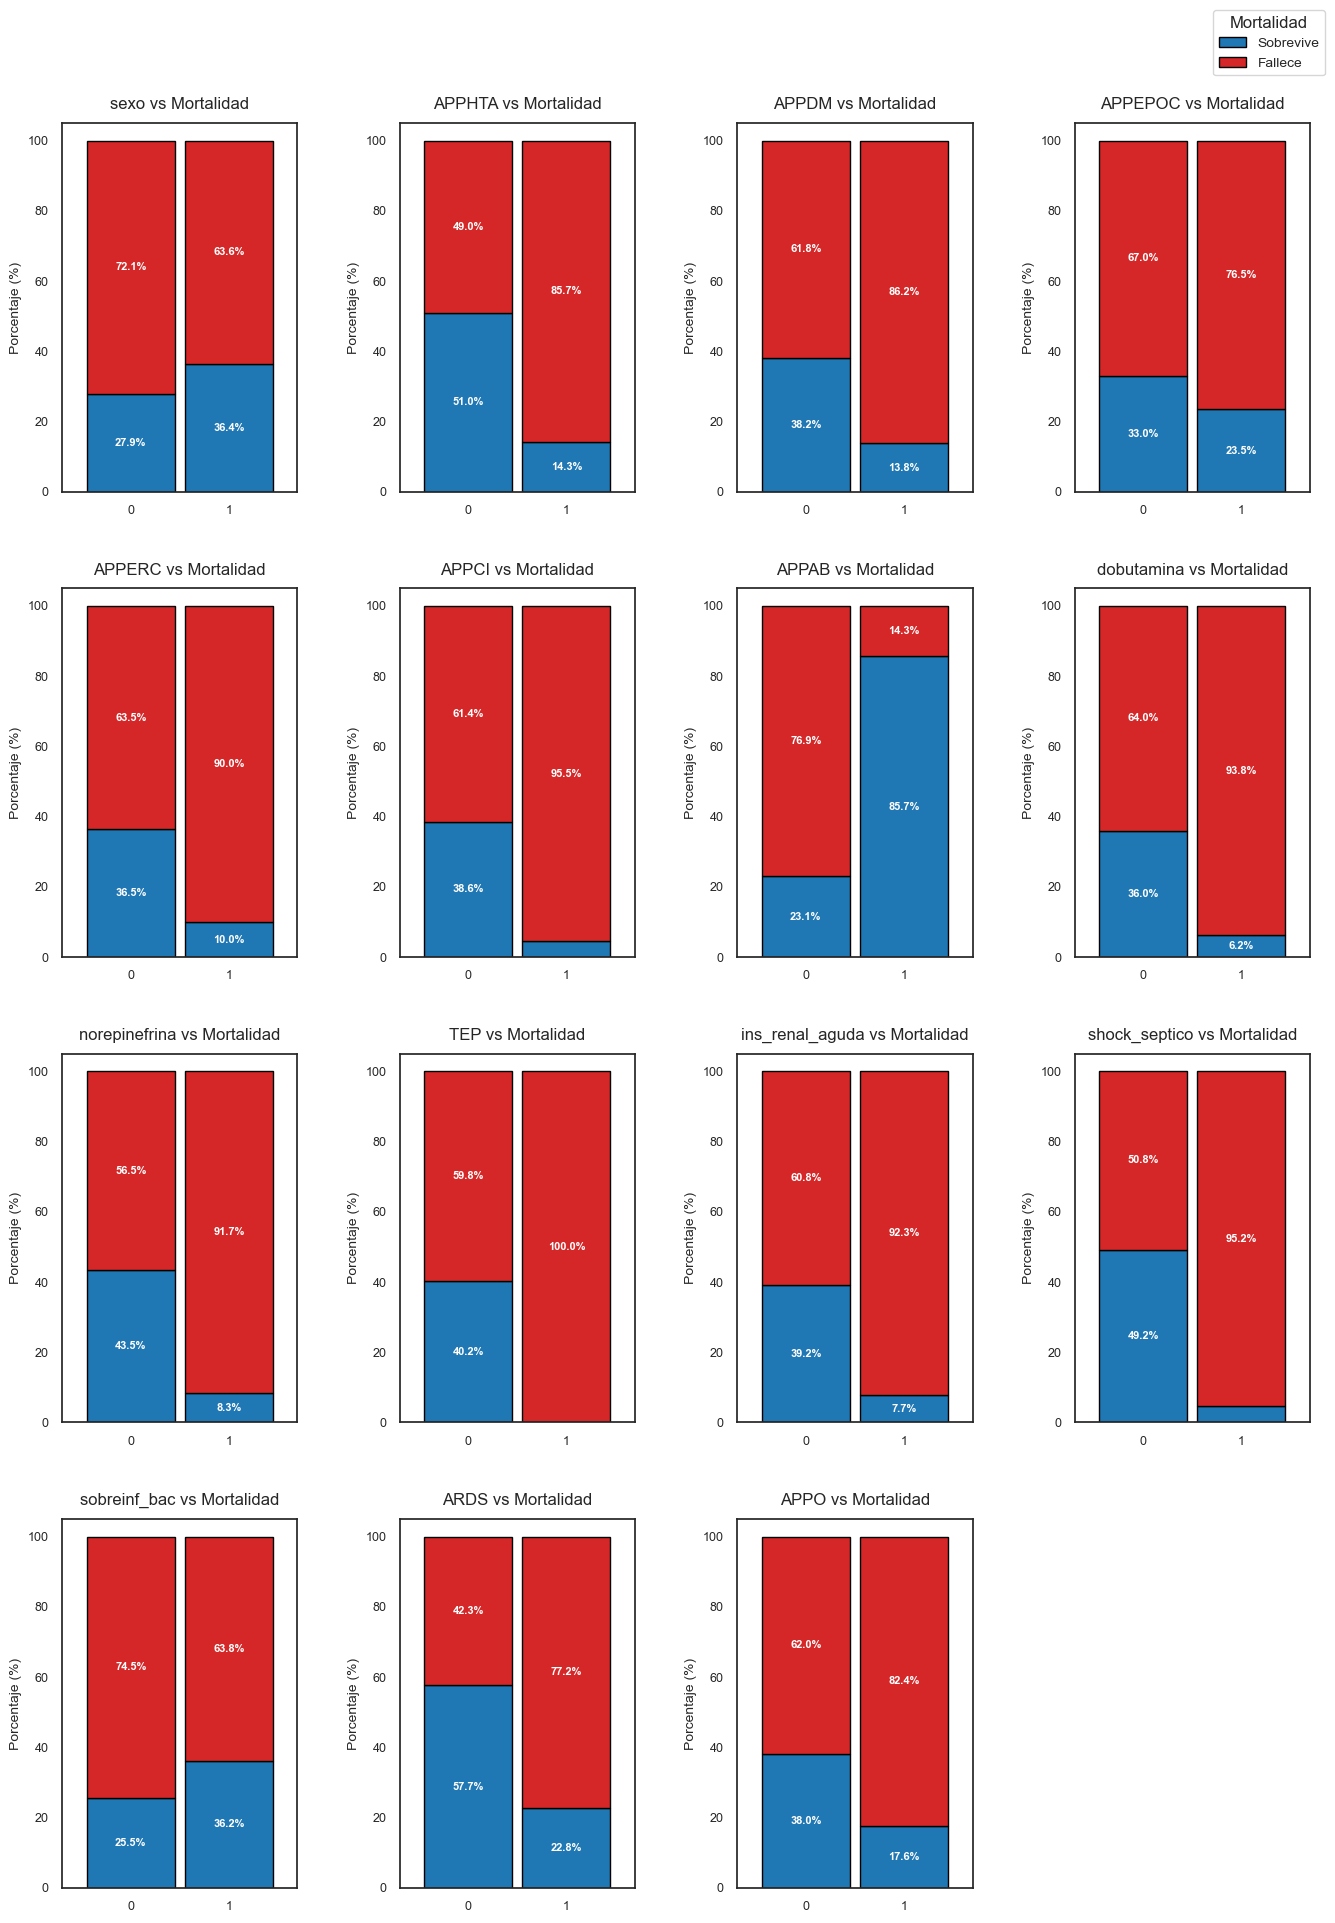

In [103]:
#Representacion grafica
sns.set_style("white")
n_rows = (len(categorical_cols) + 3) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(14, 5 * n_rows))
axes = axes.flatten() 
colores = ["#1f77b4", "#d62728"]  # Azul: Sobrevive, Rojo: Fallece
for i, categ in enumerate(categorical_cols):
    tabla = pd.crosstab(train_set[categ], train_set["egreso"], normalize="index") * 100
    ax = tabla.plot(
        kind="bar",
        stacked=True,
        color=colores,
        ax=axes[i],
        edgecolor="black",
        width=0.9 
    )
    ax.set_title(f"{categ} vs Mortalidad", fontsize=12, pad=10)
    ax.set_xlabel("")
    ax.set_ylabel("Porcentaje (%)", fontsize=10)
    ax.legend_.remove()  
    ax.tick_params(axis="x", labelsize=9, rotation=0)
    ax.tick_params(axis="y", labelsize=9)
    for barra in ax.patches:
        width, height = barra.get_width(), barra.get_height()
        x, y = barra.get_xy()
        if height > 5: 
            ax.text(
                x + width/2, 
                y + height/2, 
                f"{height:.1f}%", 
                ha="center", 
                va="center", 
                color="white",
                fontsize=8,
                fontweight="bold"
            )
fig.legend(
    ["Sobrevive", "Fallece"],
    title="Mortalidad",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    fontsize=10
)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)  
plt.show()

In [98]:
X_test = test_set.drop(["egreso"] , axis="columns")
y_test = test_set.egreso
X_train  = train_set.drop(["egreso"] , axis="columns")
y_train = train_set.egreso
#Usar un XGBoost como modelo base para calcular la importancia de las caracteristicas
scale = (y_train == 0).sum() / (y_train == 1).sum() 
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42 ,
    scale_pos_weight=scale # Ajuste de peso para clases desbalanceadas (mas fallecidos que sobrevivientes)
)
# CONFIGURAR RFE (Selección de características recursiva)
rfe = RFE(
    estimator=xgb_base,
    step=1, 
    verbose=0
)
#Definir el espacio de busqueda de hiperparametros para GridSearchCV
parametros = {
    # Hiperparámetros de XGBoost (dentro de RFE)
   'estimator__n_estimators':  [20,30,40,50,60,70,80,90,100],
    'estimator__max_depth':     [3,5,7,6,4,8],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.3 ],
    # Número de características finales que RFE debe conservar
    'n_features_to_select':     [4,5,6,7,8,9,10]
}

grid_rfe = GridSearchCV(
    estimator=rfe,
    param_grid=parametros,
    scoring="roc_auc",  # Métrica de evaluación: AUC-ROC
    cv=5,               # Validación cruzada con 5 particiones
    n_jobs=-1,        
    verbose=2
)
grid_rfe.fit(X_train, y_train)
print("Mejor ROC-AUC (CV):", grid_rfe.best_score_)
print("Mejores parámetros:", grid_rfe.best_params_)
best_rfe = grid_rfe.best_estimator_
#Caracteristicas seleccionadas por RFE
selected_features = X_train.columns[best_rfe.support_]
"""
3 min 31 seg
Mejor ROC-AUC (CV): 0.9153061224489797
Mejores parámetros: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 80, 'n_features_to_select': 6}
"""


Fitting 5 folds for each of 1512 candidates, totalling 7560 fits


c:\Users\David_858\miniconda3\envs\My_Environment\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejor ROC-AUC (CV): 0.9153061224489797
Mejores parámetros: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 80, 'n_features_to_select': 6}


"\n3 min 31 seg\nMejor ROC-AUC (CV): 0.9153061224489797\nMejores parámetros: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 80, 'n_features_to_select': 6}\n"

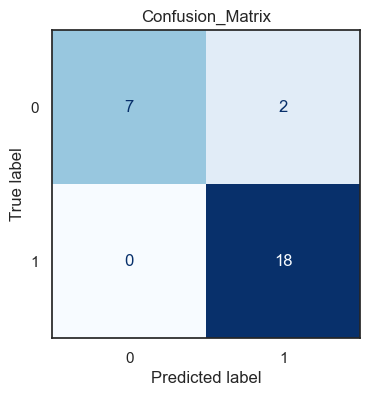

In [104]:
#Resultados sobre el Test_Set
xgb_base = best_rfe.estimator_
y_pred = xgb_base.predict(X_test[selected_features])
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
ax.set_title("Confusion_Matrix")
plt.show()

In [ ]:
#Mostrar un ranking de caracteristicas . 1-Elegidas por el modelo  
rfe_ranking = best_rfe.ranking_  
df_ranking = pd.DataFrame({
    'feature': X_train.columns,
    'rfe_rank': rfe_ranking
})
xgb_params = {
    'n_estimators':   grid_rfe.best_params_['estimator__n_estimators'],
    'max_depth':      grid_rfe.best_params_['estimator__max_depth'],
    'learning_rate':  grid_rfe.best_params_['estimator__learning_rate'],
    'objective':      'binary:logistic',
    'eval_metric':    'logloss',
    'random_state':   42
}
xgb_full = xgb.XGBClassifier(**xgb_params)
xgb_full.fit(X_train, y_train)
df_ranking['importancia_xgb'] = xgb_full.feature_importances_
df_ranking = df_ranking.sort_values(by='rfe_rank', ascending=True).reset_index(drop=True)
df_ranking

,feature,rfe_rank,importancia_xgb
0,edad,1,0.151440
1,APPAB,1,0.128010
2,shock_septico,1,0.055021
3,TEP,1,0.095177
4,dimero_d,1,0.058390
5,LDH,1,0.118648
6,ferritina,2,0.067129
7,apache_II,3,0.127856
8,neutro/linfo,4,0.029802
9,ins_renal_aguda,5,0.038397
